In [2]:
# import dependencies
import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

# For ploting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nmslib

import sys
import pickle

useGPU = torch.cuda.is_available()

In [3]:
# define useful utility function
de# define our transformation function
centre_crop = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the data with cocoAPI this time we dont need transform
cap = dset.CocoCaptions(root = '/home/raille/coco-features/coco-dataset/train2017',
                        annFile = '/home/raille/coco-features/coco-dataset/annotations/captions_train2017.json',
                        transform=centre_crop)f imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.figure()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def progress(count, total, suffix=''):
    """ Shows the progress of a given action 
    
    @params:
    - count : the current count of done operations
    - total : the total number of operation to do
    - suffix : a message printed after the progress bar
    """
    
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ... %s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()
    
def compute_sim_percentage_arrays(array_1, array_2):
    """
        Compute the percentage of similarity between 2 1D IntTensor of same lentgh
    """
    return (array_1 == array_2).sum()/len(array_1)

In [4]:
# define our transformation function
centre_crop = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the # load the raw and PCA features
raw_features = torch.load('../data/raw-features-scaled.pt')
PCA_features = torch.load('../data/PCA-features-scaled.pt')data with cocoAPI this time we dont need transform
cap = dset.CocoCaptions(root = '/home/raille/coco-features/coco-dataset/train2017',
                        annFile = '/home/raille/coco-features/coco-dataset/annotations/captions_train2017.json',
                        transform=centre_crop)

loading annotations into memory...
Done (t=3.00s)
creating index...
index created!


In [5]:
# load the raw and PCA features
raw_features = torch.load('../data/raw-features-scaled.pt')
PCA_features = torch.load('../data/PCA-features-scaled.pt')

## Perform kNN

#### raw features

In [16]:
data = raw_features.cpu().numpy()

In [17]:
%%time
# initialize a new index, using a HNSW index on l2 norm
index = nmslib.init(method='hnsw', space='l2')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

CPU times: user 20min 16s, sys: 5.57 s, total: 20min 22s
Wall time: 1min 1s


In [18]:
%%time
neighbours_raw = index.knnQueryBatch(data, k=2, num_threads=4)

CPU times: user 32.1 s, sys: 1.51 s, total: 33.6 s
Wall time: 8.84 s


#### pca features

In [19]:
data = PCA_features.cpu().numpy()

In [20]:
%%time
# initialize a new index, using a HNSW index on l2 norm
index = nmslib.init(method='hnsw', space='l2')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

CPU times: user 4min 49s, sys: 1.43 s, total: 4min 50s
Wall time: 15 s


In [21]:
%%time
neighbours_pca = index.knnQueryBatch(data, k=2, num_threads=4)

CPU times: user 7.24 s, sys: 108 ms, total: 7.35 s
Wall time: 2.06 s


#### put to file for bleu score

In [27]:
# create the match index files for the bleu score script
pickle.dump([x[0][1] for x in neighbours_raw], open("../data/match_index_nmslib_raw.pl", "wb"))
pickle.dump([x[0][1] for x in neighbours_pca], open("../data/match_index_nmslib_pca.pl", "wb"))

## Assess Result

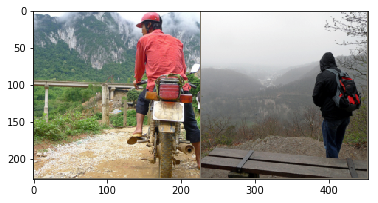

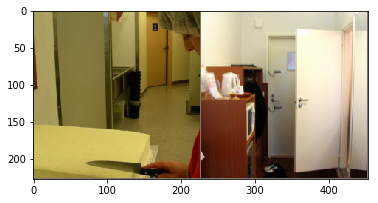

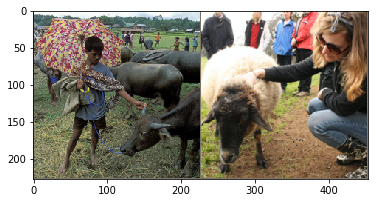

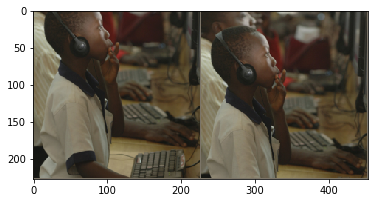

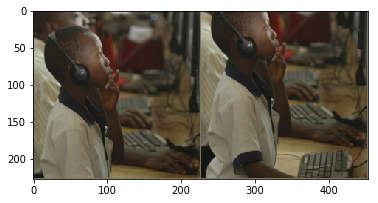

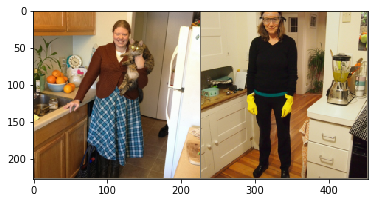

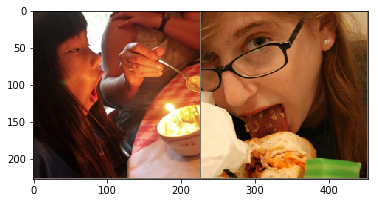

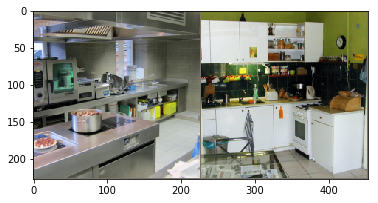

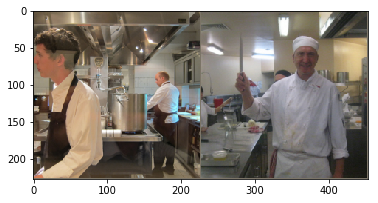

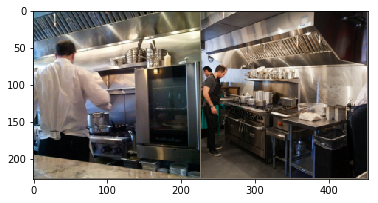

In [28]:
# display the 10 first match for the raw features
for i in range(0,10):
    matched_index = neighbours_raw[i][0][1]
    imshow(torchvision.utils.make_grid([cap[i][0], cap[matched_index][0]], nrow=2))

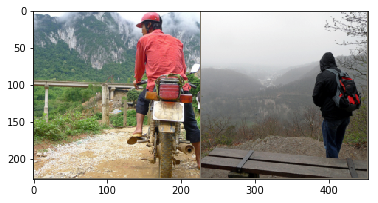

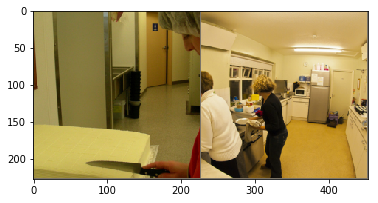

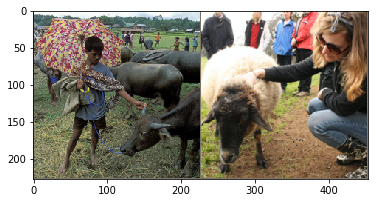

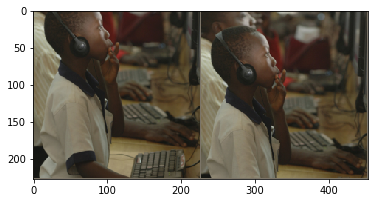

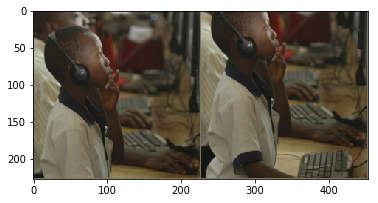

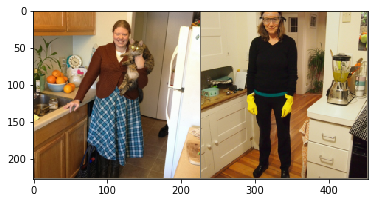

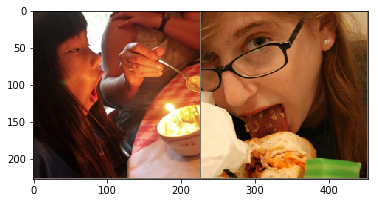

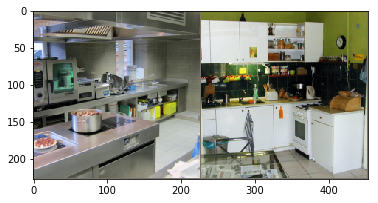

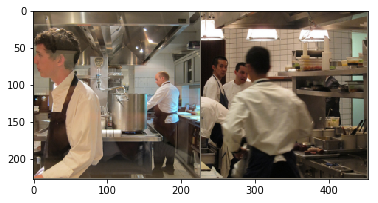

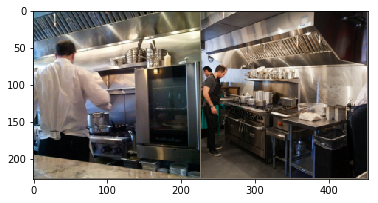

In [29]:
# display the 10 first match for the pca features
for i in range(0,10):
    matched_index = neighbours_pca[i][0][1]
    imshow(torchvision.utils.make_grid([cap[i][0], cap[matched_index][0]], nrow=2))

In [30]:
%%time
compute_sim_percentage_arrays(np.array([x[0][1] for x in neighbours_pca]), 
                              np.array([x[0][1] for x in neighbours_raw]))

CPU times: user 61.8 ms, sys: 20.1 ms, total: 81.9 ms
Wall time: 80 ms


0.69107340620693736

#### For the bleu score I used the sh script to parallelize the process

In [31]:
# raw feature bleu score:
with open("../scripts/mean_bleu_nmslib_raw.txt") as f:
    read_data = f.read()
    
# check that every script runned well
if len(read_data.split(',')[0:-1]) == 24:
    print("Bleu score for the raw nmslib match feature: {}".format(
        np.mean([float(i) for i in read_data.split(',')[0:-1]])))

Bleu score for the raw nmslib match feature: 0.5929405020442083


In [33]:
# pca feature bleu score:
with open("../scripts/mean_bleu_nmslib_pca.txt") as f:
    read_data = f.read()
    
# check that every script runned well
if len(read_data.split(',')[0:-1]) == 24:
    print("Bleu score for the pca nmslib match feature: {}".format(
        np.mean([float(i) for i in read_data.split(',')[0:-1]])))

Bleu score for the pca nmslib match feature: 0.5932188125206249
